In [1]:
from model import *
from data import *

## Train your Unet with CT scan data
CT data is in folder dataset/

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [11]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(1,'dataset/datas/','allimages','allmasks',data_gen_args,save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_covid.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(myGene,steps_per_epoch=1,epochs=20,callbacks=[model_checkpoint])

C:\Users\prast\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.9861
Epoch 00001: loss improved from inf to 0.69315, saving model to unet_covid.hdf5
1/1 [==============================] - 16s 16s/step - loss: 0.6931 - accuracy: 0.9861
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.9488
Epoch 00002: loss improved from 0.69315 to 0.69309, saving model to unet_covid.hdf5
1/1 [==============================] - 12s 12s/step - loss: 0.6931 - accuracy: 0.9488
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.9741
Epoch 00003: loss improved from 0.69309 to 0.69303, saving model to unet_covid.hdf5
1/1 [==============================] - 12s 12s/step - loss: 0.6930 - accuracy: 0.9741
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.9877
Epoch 00004: loss improved from 0.69303 to 0

In [3]:
#model.summary()

### Test your model and save predicted results

In [12]:
testGene = testGenerator("dataset/alltest/")
model = unet()
model.load_weights("unet_covid.hdf5")
results = model.predict_generator(testGene,10,verbose=1)
# saveResult("dataset/alltest",results)

C:\Users\prast\AppData\Local\Temp/ipykernel_10260/3189175099.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = model.predict_generator(testGene,10,verbose=1)


10/10 [==============================] - 17s 2s/step


In [5]:
#results.shape

In [6]:
#import matplotlib.pyplot as plt


In [7]:
#plt.imsave('predict-0.jpg',results[0,:,:,0],cmap="gray")

In [8]:
#plt.imshow(results[0,:,:,:])

In [9]:
#plt.imshow(results[1,:,:,:])

In [10]:
#results[0,:,:,:].shape

## GradCAM implementation to see regions of interest


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
#from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [14]:
preprocess_input = keras.applications.xception.preprocess_input
img_size = (512, 512)
last_conv_layer_name = "conv2d_47"
img_path = ('dataset/alltest/0_predict.jpg')
#display(Image(img_path))

In [15]:
from PIL import Image
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm
import glob


In [42]:
def read_images(path):
    filelist = glob.glob(f'{path}/*.jpg')
    x = np.array([np.array(Image.open(fname)) for fname in filelist],dtype='float32')
    x = x/255. 
    return x

def visualize_gradCAM(data,image_titles,model,category):
    replace2linear = ReplaceToLinear()
    score = CategoricalScore(category)

    # Create Gradcam object
    gradcam = Gradcam(model,model_modifier=replace2linear,clone=True)

   # Generate heatmap with GradCAM
    cam = gradcam(score,data,penultimate_layer=-1)
    
    # Render
    f, ax = plt.subplots(nrows=1, ncols=data.shape[0], figsize=(12, 4))
    for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=16)
        print(data[i].shape)
        ax[i].imshow(data[i][:, :, 0])
        ax[i].imshow(heatmap, cmap='jet', alpha=0.2) # overlay
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

In [43]:
# img_path1 = ('dataset/alltest/0_predict.jpg')
img_path2 = 'dataset/alltest/'
img_array1 = read_images(img_path2)

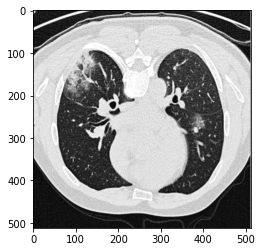

In [50]:
img_array1.shape
# img_array1[:,:,:,0:1].shape
img_array2 = img_array1[:,:,:,0:1]
plt.imshow(img_array1[0,:,:,0:1],cmap = 'gray')

### GRADCAM implementation for two images: left image(test image), right image(mask of image)

(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)


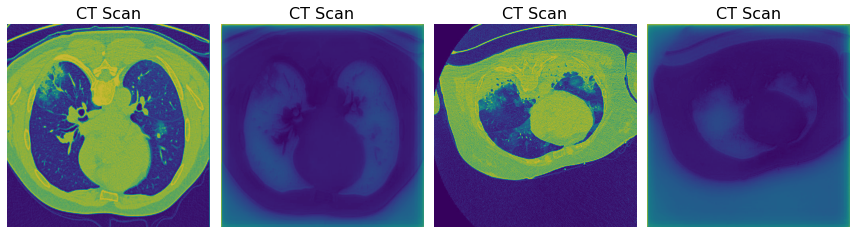

In [46]:
image_titles1 = ['CT Scan']*4
visualize_gradCAM(img_array2[0:4],image_titles1,model,category=[0,0,0,0])